#### Funci칩n de solapamiento: 

El objetivo de este fichero es documentar la funci칩n de solapamiento aplicado a los mapas objetivos. Para ello utilizaremos un mapa HGT como ejemplo.

shape:  (384, 416)


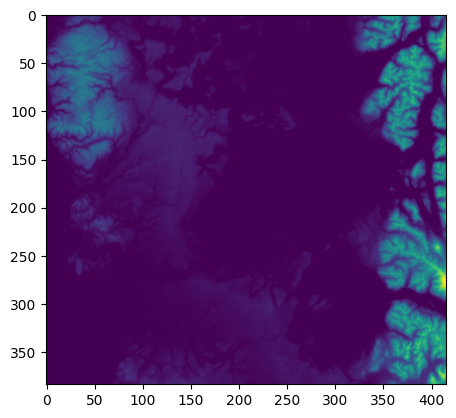

In [177]:
import matplotlib.pyplot as plt 
import numpy as np 


hgt = np.load("extra/files/wrfout_d05_2015-10-25_23:00:00.npy")[0,0]

print("shape: ", hgt.shape)   
plt.imshow(hgt)

#### 1. Idea 游눠

La idea es simple, debido a que la longitud de los parches se conserva (longitud $(32,32)$), basta con simplemente desplazar este "molde cortador" de parches una cantidad constante para cumplir con este solapamiento, similar al comportamiento del  "kernel" y el "stride" dentro de las redes CNN. Trabajaremos con 3 desplazamientos diferentes: de 8, de 16 y de 24, con el fin de evaluar de manera completa el efecto de solapar parches en nuestro modelo Unet.

Para efectos de la zona objetivo, a 칠sta le integraremos un padding de tama침o $((32,32), (32,32))$ independiente del desplazamiento del molde. Utilizaremos dos tipos de padding: un padding "constante", que agrega valores 0, y un padding 'reflect', que reflecta los valores internos del borde al exterior. 

Un ejemplo de lo anterior se encuentre en la siguiente figura. Nuestra zona objetivo originalmente tiene dimensiones (384,416), una vez aplicado el padding, pasar칤a a tener dimensiones $(448, 480)$. Ahora bien, la elecci칩n del tama침o del padding es netamente para facilitar la construcci칩n del futuro c칩digo, ya que dependiendo del desplazamiento escogido, el inicio de los cortes cambiar치.

Tama침o del mapa original:  (384, 416)
Tama침o del mapa con padding reflect:  (448, 480)
Tama침o del mapa con padding same:  (448, 480)


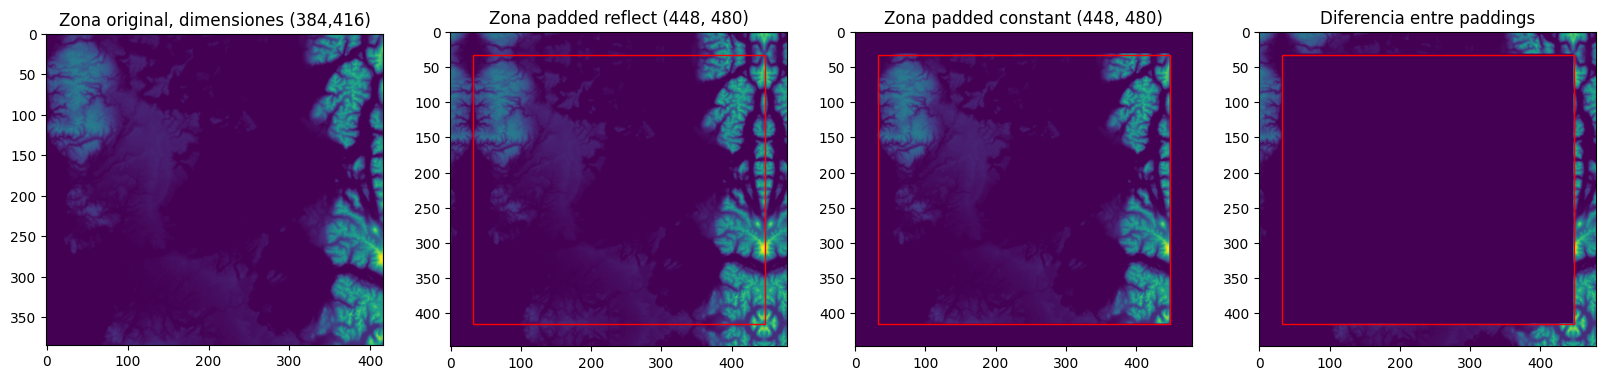

In [178]:
import matplotlib.patches as patches

hgt_reflect = np.pad(hgt, ((32, 32), (32, 32)), mode='reflect')
hgt_same    = np.pad(hgt, ((32, 32), (32, 32)), mode='constant')

print("Tama침o del mapa original: ", hgt.shape)
print("Tama침o del mapa con padding reflect: ", hgt_reflect.shape)
print("Tama침o del mapa con padding same: ", hgt_same.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(hgt, cmap='viridis')
ax1.set_title('Zona original, dimensiones (384,416)')

ax2.imshow(hgt_reflect, cmap='viridis')
rect2 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect2)
ax2.set_title(f'Zona padded reflect {hgt_reflect.shape}')

ax3.imshow(hgt_same, cmap='viridis')
rect3 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax3.add_patch(rect3)
ax3.set_title(f'Zona padded constant {hgt_same.shape}')

ax4.imshow(hgt_reflect - hgt_same, cmap='viridis')
rect4 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax4.add_patch(rect4)
ax4.set_title(f'Diferencia entre paddings')

plt.show()

#### 2. L칤mites de corte: 

A excepci칩n del desplazamiento de tama침o 24, los desplazamientos restantes: $8$ y $16$, al ser ambos divisores de 32, crear치n un mallado sim칠trico en nuestra zona padded. Esta falta de simetr칤a en uno de nuestros desplazamientos ser칤a relevante si nuestra prioridad en las predicciones no solo fuera la zona interna del mapa sino tambi칠n los bordes, por lo cual no forzaremos esta caracter칤stica para este desplazamiento. 

El inicio del proceso de corte vendr치 dado por el tama침o del solapamiento, es decir, si escogemos 8 como desplazamiento, el primer corte (o tambi칠n considerado como borde exterior), ser치 en el valor 8 de la zona padded. Luego solo resta ir moviendose 8 espacios.

In [179]:
def calcular_cortes(solap=int, shape_padded=(448,480)):
    ''' Funci칩n que calcula la posici칩n de los cortes verticales y horizontales
        considerando solapamiento.
    input:
        solap: [int] Tama침o del desplazamiento. Las opciones son 8,16 y 24
        shape_padded [tupla]: Tama침o de la zona post padding. Valor default igual 
        a padding ((32,32),(32,32))
    return: 
        cortes_x, cortes_y [list] Lista de tuplas pares que contienen la posici칩n de 
        cortado de los parches en ambas direcciones.
    ''' 
    cortes_x = np.arange(solap, shape_padded[0], solap)
    cortes_y = np.arange(solap, shape_padded[1], solap)
    cortes_y = [(i, i + 32) for i in cortes_y if i+32 < shape_padded[1]] 
    cortes_x = [(i, i + 32) for i in cortes_x if i+32 < shape_padded[0]]

    return cortes_x, cortes_y

cortes_x, cortes_y = calcular_cortes(solap=8)
print("Ejemplo de la posici칩n de los cortes verticales: ", cortes_y[:3], "...", cortes_y[-3:])
print("Ejemplo de la posici칩n de los cortes horizontales: ", cortes_x[:3], "...", cortes_x[-3:])

Ejemplo de la posici칩n de los cortes verticales:  [(8, 40), (16, 48), (24, 56)] ... [(424, 456), (432, 464), (440, 472)]
Ejemplo de la posici칩n de los cortes horizontales:  [(8, 40), (16, 48), (24, 56)] ... [(392, 424), (400, 432), (408, 440)]


#### Visualizaci칩n de los cortes

Para visualizar los cortes, utilizaremos "rect치ngulos" que representar치n a un parche cortado. Ahora bien, debido a que estamos trabajando con parches solapados, los contornos de estos rect치ngulos se ir치n superponiendo, produciendo la siguiente figura. 

Nota: Se visualiza la esquina superior izquierda de cada parche. Los colores fueron alternados para facilitar la visualizaci칩n.

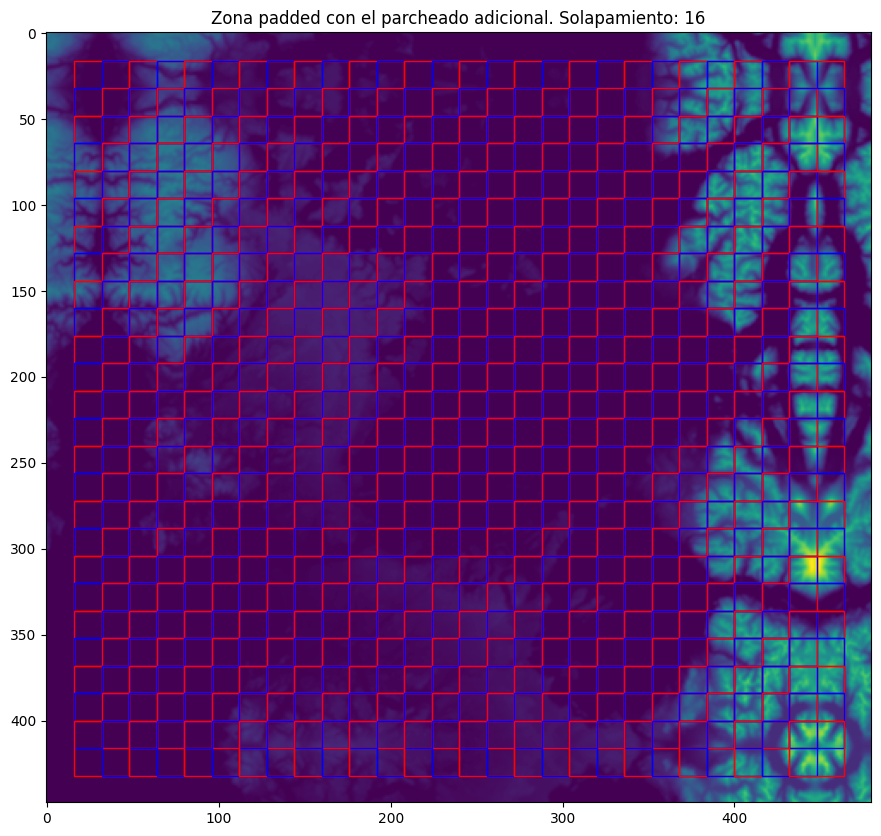

In [180]:
solap=16
cortes_x, cortes_y = calcular_cortes(solap=solap)

color = ["red", "blue"]
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

### Gr치fico 2: Nuevo parcheado - Zona padded  
ax1.imshow(hgt_reflect, cmap='viridis')
ax1.set_title(f'Zona padded con el parcheado adicional. Solapamiento: {solap}')
k=0
for j in cortes_y: #lineas horizontales
    for i in cortes_x:
        rect=patches.Rectangle((j[0], i[0]), 32, 32, linewidth=1, edgecolor=color[k % 2], facecolor="None") 
        ax1.add_patch(rect)
        k += 1

#### 3. Proceso de cortado

El proceso de cortado se har치 mediante una simple indexaci칩n del tensor que contiene al mapa. Para ello, utilizaremos los cortes creados previamente como l칤mites de cortado:

Nota: Resta adaptar esta funci칩n para el tensor que contendr치 a todos los mapas.

In [183]:
hgt_padded = hgt_reflect
stack = np.zeros( (1,32,32))

for i in cortes_x: 
    for j in cortes_y:
        hgt_ij = np.expand_dims ( hgt_padded[ i[0]: i[1], j[0]:j[1]], axis=0)
        stack = np.concatenate((stack, hgt_ij), axis=0)
stack = stack[1:]
print("Dimensi칩n del vector stack: ", stack.shape)

Dimensi칩n del vector stack:  (675, 32, 32)


#### 4. Proceso de reconstrucci칩n

La idea es reconstruir los mapas originales (considerando el solapamiento aplicado) para comprobar que el proceso de cortado fue hecho correctamente. Como el solapamiento utilizado para ejemplificar es de 16, en caso de querer reconstruir el mapa completo, tenemos que tener en cuenta dos cosas: 
- (1) De manera horizontal, parche por medio ser치n independientes y por ende, pasar치n a formar un mismo mapa. Para resolver esto, basta con utilizar la indexaci칩n [::2] propia de los tensores.
- (2) De manera vertical, cada 14 parches pasar치n a formar parte de un mismo mapa. Para resolver esto, crearemos una lista de 칤ndices personalizadas que contenga los 14 primeros 칤ndices, luego se salte los 14 siguientes y vuelva tomar otros 14, y as칤 sucesivamente. 

Para atender el primer punto, extraeremos cada 27 parches (correspondientes a una misma fila solapada) y le aplicaremos la indexaci칩n [::2]

In [184]:
stacker = np.zeros((1,32,32))
for i in range(12*13): 
    stack_14_elem = stack[27*i : 27*(i+1)] #cada 27 elementos (una fila)
    stack_cada_2 = stack_14_elem[::2] #excluyo uno por medio
    stacker = np.concatenate((stacker, stack_cada_2), axis=0)
stacker=stacker[1:]
print("Dimensi칩n del stack modificado direcci칩n horizontal: ", stacker.shape)

Dimensi칩n del stack modificado direcci칩n horizontal:  (350, 32, 32)


Para atender el segundo punto, creamos esta lista de 칤ndices personalizada sin pasarnos del m치ximo y reindexamos nuestro stack anteriormente creado:

In [186]:
take = 14 #cu치ntos elementos tomamos
skip = 14 #cu치ntos elementos nos saltamos 

n = stacker.shape[0]
indices = np.concatenate([np.arange(i, i + take) for i in range(0, n, take + skip) if i + take <= n])

#re-indexaci칩n del stack
subset = stacker[indices]
print("Dimensi칩n del stack modificado direcci칩n vertical: ", subset.shape)

Dimensi칩n del stack modificado direcci칩n vertical:  (182, 32, 32)


Para visualizar el mapa constru칤do, creamos un vector de ceros con las dimensiones del nuevo mapa: $(13*32, 14*32)$, e iremos reemplazando sus valores con los parches almacenados en el stack de izquierda a derecha y de arriba para abajo.

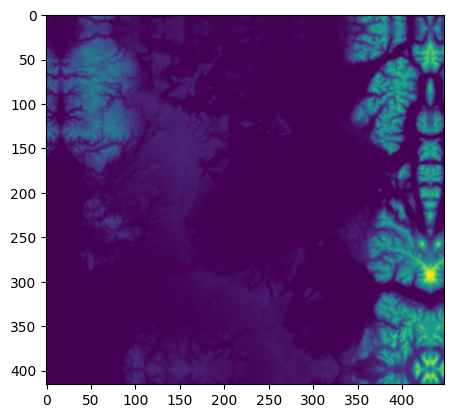

In [187]:
reconstructed_map = np.zeros((416, 448))
index=0
for i in range(13):  # 13 filas
    for j in range(14):  # 14 columnas
        reconstructed_map[i*32:(i+1)*32, j*32:(j+1)*32] = subset[index]
        index += 1

plt.imshow(reconstructed_map) 

Finalmente, restamos los valores del mapa reconstru칤do con el mapa padded para comprobar que la diferencia entre ellos es nula y por ende, el vector reconstru칤do es el mismo que el original (versi칩n padded):

In [189]:
hgt_padded_slope_16 = hgt_reflect[16:, 16:] #exclu칤mos los primeros 16 valores tanto en filas como columnas
hgt_target = hgt_padded_slope_16[:-16, :-16] #exclu칤mos los 칰ltimos 16 valores tanto en filas como columnas

if np.sum( hgt_target - reconstructed_map ) == 0:
    print("Mapa reconstru칤do igual al mapa target")

Mapa reconstru칤do igual al mapa target


Repetiremos este mismo proceso pero para los parches exclu칤dos:

In [195]:
stacker = np.zeros((1,32,32))
for i in range(12*13): 
    stack_14_elem = stack[27*i : 27*(i+1)] #cada 27 elementos (una fila)
    stack_cada_2 = stack_14_elem[1::2] #excluyo uno por medio, comenzando por el segundo t칠rmino
    stacker = np.concatenate((stacker, stack_cada_2), axis=0)
stacker=stacker[1:]
print("Dimensi칩n del stack modificado direcci칩n horizontal: ", stacker.shape)


take = 13; skip = 13

n = stacker.shape[0]
indices = np.concatenate([np.arange(i, i + take) for i in range(13, n, take + skip) if i + take <= n])
subset = stacker[indices]

print("Dimensi칩n del stack modificado direcci칩n vertical: ", subset.shape)

Dimensi칩n del stack modificado direcci칩n horizontal:  (325, 32, 32)
Dimensi칩n del stack modificado direcci칩n vertical:  (156, 32, 32)


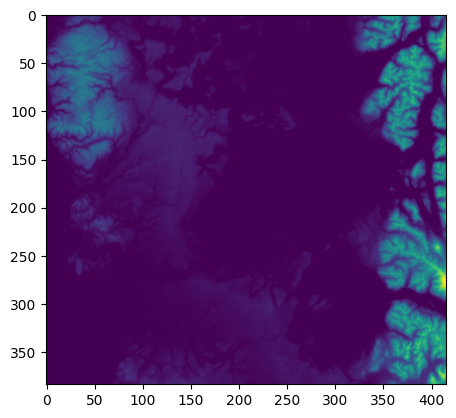

In [198]:
reconstructed_map = np.zeros((12*32, 13*32))
index=0
for i in range(12):  # 13 filas
    for j in range(13):  # 14 columnas
        reconstructed_map[i*32:(i+1)*32, j*32:(j+1)*32] = subset[index]
        index += 1

plt.imshow(reconstructed_map) 

In [199]:
hgt_padded_slope_16 = hgt_reflect[32:, 32:] #exclu칤mos los primeros 16 valores tanto en filas como columnas
hgt_target = hgt_padded_slope_16[:-32, :-32] #exclu칤mos los 칰ltimos 16 valores tanto en filas como columnas

if np.sum( hgt_target - reconstructed_map ) == 0:
    print("Mapa reconstru칤do igual al mapa target")

Mapa reconstru칤do igual al mapa target
